Agriculture Production of different Food Grains

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, stack, regexp_extract, trim, lower, when, regexp_replace, monotonically_increasing_id
import matplotlib.pyplot as plt
import numpy as np
import re

# --- 1. Initialize Spark Session ---
try:
    spark = SparkSession.builder.appName("AgriculturalProductionAnalysis").getOrCreate()
except Exception as e:
    print(f"Error initializing Spark Session: {e}")
    spark = SparkSession.builder.getOrCreate()


In [2]:

# --- 2. Load Data ---
file_path = "Production-Department_of_Agriculture_and_Cooperation_1.csv" 

df_raw = spark.read.csv(
    file_path, 
    header=True, 
    inferSchema=True,
    quote='"', 
    escape='"', 
    multiLine=True
)

In [3]:
# --- 3. Identify and Clean Year Columns ---
year_cols = [c for c in df_raw.columns if re.match(r'^\s*\d+-\d+', c)]
safe_year_cols = [f"Y_{c.replace('-', '_').strip()}" for c in year_cols]
rename_map = dict(zip(year_cols, safe_year_cols))
df = df_raw.select([col(c).alias(rename_map.get(c, c)) for c in df_raw.columns])


In [4]:
# --- 4. Unpivot/Melt the Data ---
stack_parts = []
for c in safe_year_cols:
    stack_parts.append(f"'{c}', `{c}`")

stack_cols_expr = ", ".join(stack_parts)
stack_expr = f"stack({len(safe_year_cols)}, {stack_cols_expr}) as (Year_Column, Value_Raw)" # Renamed Value to Value_Raw

# Apply the unpivot using selectExpr
df_long = df.selectExpr(
    "Particulars", 
    "Frequency", 
    "Unit", 
    stack_expr
)

# Convert Year_Column to a clean integer Year
df_long = df_long.withColumn(
    "Year",
    regexp_extract(col("Year_Column"), r'(\d{4})$', 1).cast("int")
).drop("Year_Column")


# **VITAL FIX: Explicitly replace 'NA' with null BEFORE casting**
df_long = df_long.withColumn(
    "Value", 
    when(lower(trim(col("Value_Raw"))) == "na", lit(None).cast("float"))
    .otherwise(col("Value_Raw").cast("float"))
).drop("Value_Raw") # Drop the raw column

# Drop rows where the value is null (includes replaced 'NA' entries)
df_long = df_long.dropna(subset=['Value'])


print("--- Data Schema After Unpivoting ---")
df_long.printSchema()
print("\n--- Sample of Long Data Format ---")
df_long.limit(10).show(truncate=False)

--- Data Schema After Unpivoting ---
root
 |-- Particulars: string (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Value: float (nullable = true)


--- Sample of Long Data Format ---
+----------------------------------+-------------------------------+------+----+---------+
|Particulars                       |Frequency                      |Unit  |Year|Value    |
+----------------------------------+-------------------------------+------+----+---------+
|Agricultural Production Foodgrains|Annual, Ending mar Of Each Year|Ton mn|2005|198.36282|
|Agricultural Production Foodgrains|Annual, Ending mar Of Each Year|Ton mn|2006|208.6016 |
|Agricultural Production Foodgrains|Annual, Ending mar Of Each Year|Ton mn|2007|217.28212|
|Agricultural Production Foodgrains|Annual, Ending mar Of Each Year|Ton mn|2008|230.77504|
|Agricultural Production Foodgrains|Annual, Ending mar Of Each Year|Ton mn|2009|234.46617|


In [5]:
from pyspark.sql.functions import col, lit, when, regexp_extract, trim, lower, regexp_replace

# --- 5. Parse the 'Particulars' Column ---
# Standardize and clean the particulars column for reliable parsing
df_parsed = df_long.withColumn("Particulars_Clean", lower(trim(col("Particulars"))))

# 5a. Extract Metric (Production, Area, or Yield)
df_parsed = df_parsed.withColumn(
    "Metric",
    when(col("Particulars_Clean").contains("yield"), lit("Yield"))
    .when(col("Particulars_Clean").contains("area"), lit("Area"))
    .otherwise(lit("Production"))
)

# 5b. Extract State (A simplified heuristic based on known states)
# This list is used to find state names embedded in the long 'Particulars' string.
state_list = ["andhra pradesh", "assam", "bihar", "gujarat", "haryana", "himachal pradesh", 
              "jammu & kashmir", "karnataka", "kerala", "madhya pradesh", "maharashtra", 
              "orissa", "punjab", "rajasthan", "tamil nadu", "uttar pradesh", "west bengal", 
              "all india"]

state_expression = lit("All India")
for state in state_list:
    # Check for the state name and set the column if found
    state_expression = when(col("Particulars_Clean").contains(state), lit(state.title())).otherwise(state_expression)

df_parsed = df_parsed.withColumn(
    "State_Name",
    state_expression
)

# 5c. Extract Crop (The text between "Foodgrains" and the State name/end of string)
# Step 1: Remove the state name to isolate the crop information
df_parsed = df_parsed.withColumn(
    "Crop_State_Removed",
    regexp_replace(col("Particulars_Clean"), lower(col("State_Name")), "")
)

# Step 2: Extract the text after 'foodgrains' and before the metric/end of string
# This isolates the crop name (e.g., 'Rice' from 'foodgrains rice production')
df_parsed = df_parsed.withColumn(
    "Crop_Raw",
    regexp_extract(col("Crop_State_Removed"), r'foodgrains\s*(.*?)\s*(yield|area|production|$)', 1)
)

# Step 3: Final cleanup of the Crop column (remove leading/trailing spaces)
df_parsed = df_parsed.withColumn(
    "Crop",
    trim(regexp_replace(col("Crop_Raw"), r'^\s*foodgrains\s*', ''))
)


In [6]:
# --- 6. Separate DataFrames by Metric (Production, Area, Yield) ---
# Create separate DataFrames for clean analysis
df_production = df_parsed.filter(col("Metric") == "Production")
df_area = df_parsed.filter(col("Metric") == "Area")

# Final check of the key analysis DataFrame
print("\n--- Final Production DataFrame Sample ---")
df_production.select("Year", "State_Name", "Crop", "Unit", "Value").limit(10).show(truncate=False)

print(f"\nTotal Production Records: {df_production.count()}")
print(f"Total Area Records: {df_area.count()}")


--- Final Production DataFrame Sample ---
+----+----------+----+------+---------+
|Year|State_Name|Crop|Unit  |Value    |
+----+----------+----+------+---------+
|2005|All India |    |Ton mn|198.36282|
|2006|All India |    |Ton mn|208.6016 |
|2007|All India |    |Ton mn|217.28212|
|2008|All India |    |Ton mn|230.77504|
|2009|All India |    |Ton mn|234.46617|
|2010|All India |    |Ton mn|218.10738|
|2011|All India |    |Ton mn|244.4918 |
|2012|All India |    |Ton mn|259.28625|
|2013|All India |    |Ton mn|257.13   |
|2014|All India |    |Ton mn|264.3806 |
+----+----------+----+------+---------+


Total Production Records: 2164
Total Area Records: 1074


--- 2. Crop-wise Analysis: Total Production (Top 10) ---
+---------------------------------------+-----------------------+
|Crop                                   |Total_Production_Ton_mn|
+---------------------------------------+-----------------------+
|rice volume                            |840384.3504638672      |
|wheat volume                           |784548.3194651157      |
|coarse cereals volume                  |360900.9889678955      |
|rice volume chhattisgarh               |52731.69970703125      |
|rice volume jharkhand                  |24077.799926757812     |
|wheat volume uttaranchal               |8048.0                 |
|rice volume tripura                    |6019.499938964844      |
|rice volume uttaranchal                |5800.0                 |
|coarse cereals volume jammu and kashmir|5343.9000244140625     |
|rice volume jammu and kashmir          |5327.299957275391      |
+---------------------------------------+-----------------------+



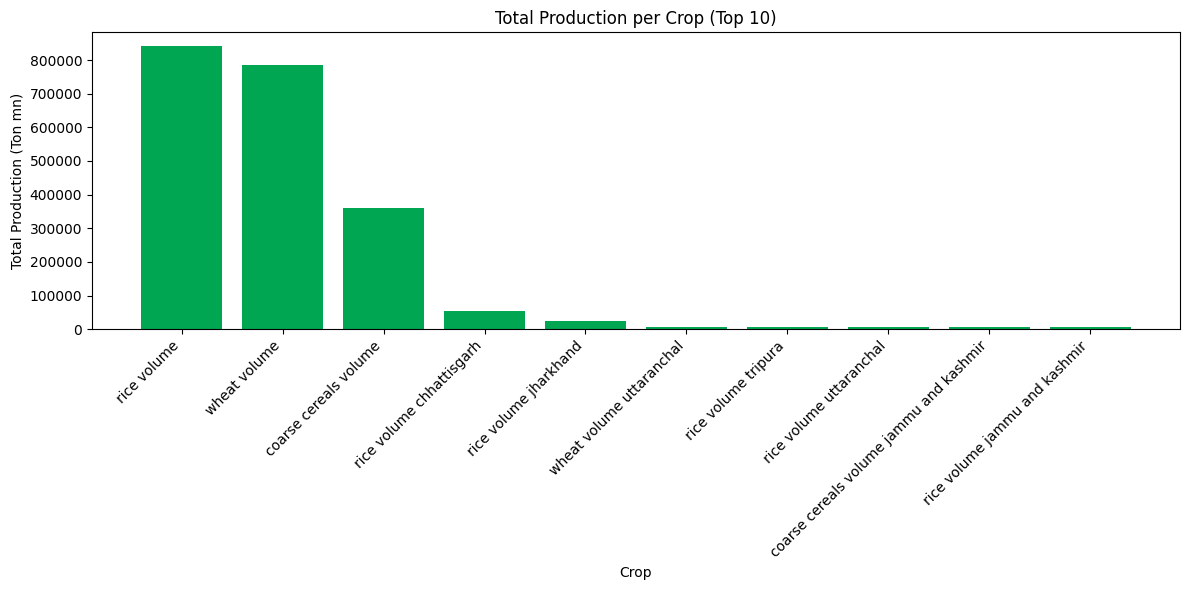


--- 3. Temporal Trends: Yearly Production ---
+----+------------------+
|Year|  Total_Production|
+----+------------------+
|1993|               0.0|
|1994|               0.0|
|1995|               0.0|
|1996| 40.51799848675728|
|1997| 13106.22999984026|
|1998| 12762.51999912411|
|1999|12608.540002077818|
|2000|12434.940000653267|
|2001|12938.529998071492|
|2002|15323.100021988153|
|2003| 16148.15999096632|
|2004|214047.48604041338|
|2005|203042.18360536546|
|2006|215147.55598870665|
|2007|  208489.293667458|
|2008|221730.36097238213|
|2009|225575.67756457627|
|2010|208641.46705368906|
|2011|230768.93652599305|
|2012|  246520.048377797|
+----+------------------+
only showing top 20 rows


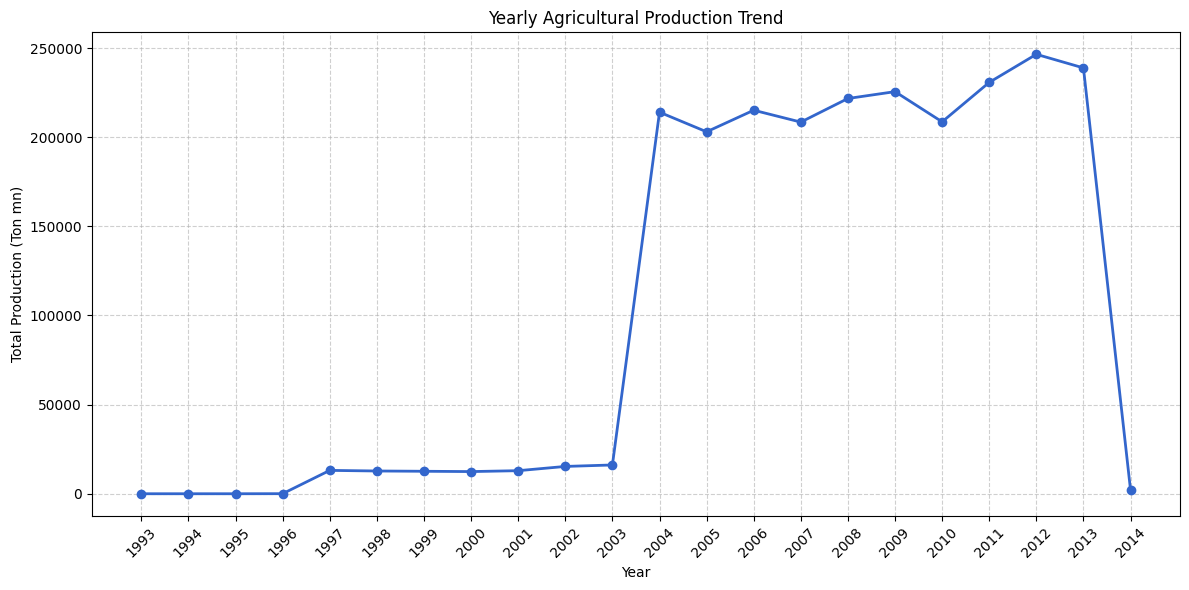

In [7]:
from pyspark.sql.functions import sum, desc
import matplotlib.pyplot as plt

# --- 2. Crop-wise Analysis (Total Production per Crop) ---
print("--- 2. Crop-wise Analysis: Total Production (Top 10) ---")

# Group by Crop and sum the Value (Production)
crop_production_df = df_production.groupBy("Crop").agg(sum("Value").alias("Total_Production_Ton_mn"))

# Filter out generic 'All India' entries if present, and sort
top_10_crops = crop_production_df.filter(col("Crop") != "").orderBy(desc("Total_Production_Ton_mn")).limit(10)
top_10_crops.show(truncate=False)

# Visualization
crop_pdf = top_10_crops.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(crop_pdf['Crop'], crop_pdf['Total_Production_Ton_mn'], color='#00a651')
plt.title('Total Production per Crop (Top 10)')
plt.xlabel('Crop')
plt.ylabel('Total Production (Ton mn)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- 3. Temporal Trends (Yearly Production) ---
print("\n--- 3. Temporal Trends: Yearly Production ---")

# Group by Year and sum the Production Value
yearly_production_df = df_production.groupBy("Year").agg(sum("Value").alias("Total_Production")).orderBy("Year")
yearly_production_df.show()

# Visualization
yearly_pdf = yearly_production_df.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(
    yearly_pdf['Year'], 
    yearly_pdf['Total_Production'], 
    marker='o', 
    linestyle='-', 
    color='#3366cc',
    linewidth=2
)
plt.title('Yearly Agricultural Production Trend')
plt.xlabel('Year')
plt.ylabel('Total Production (Ton mn)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(yearly_pdf['Year'].unique(), rotation=45)
plt.tight_layout()
plt.show()

--- 4. Regional Contribution: Top 10 States by Production ---
+--------------+------------------+
|State_Name    |Total_Production  |
+--------------+------------------+
|Uttar Pradesh |423202.29636001587|
|Punjab        |266300.62242889404|
|Andhra Pradesh|158091.70180416107|
|West Bengal   |157449.10612487793|
|Haryana       |149976.75191783905|
|Rajasthan     |139538.91648125648|
|Madhya Pradesh|121613.8664970398 |
|Bihar         |105763.62672710419|
|Karnataka     |100627.37104845047|
|Maharashtra   |100447.85142326355|
+--------------+------------------+



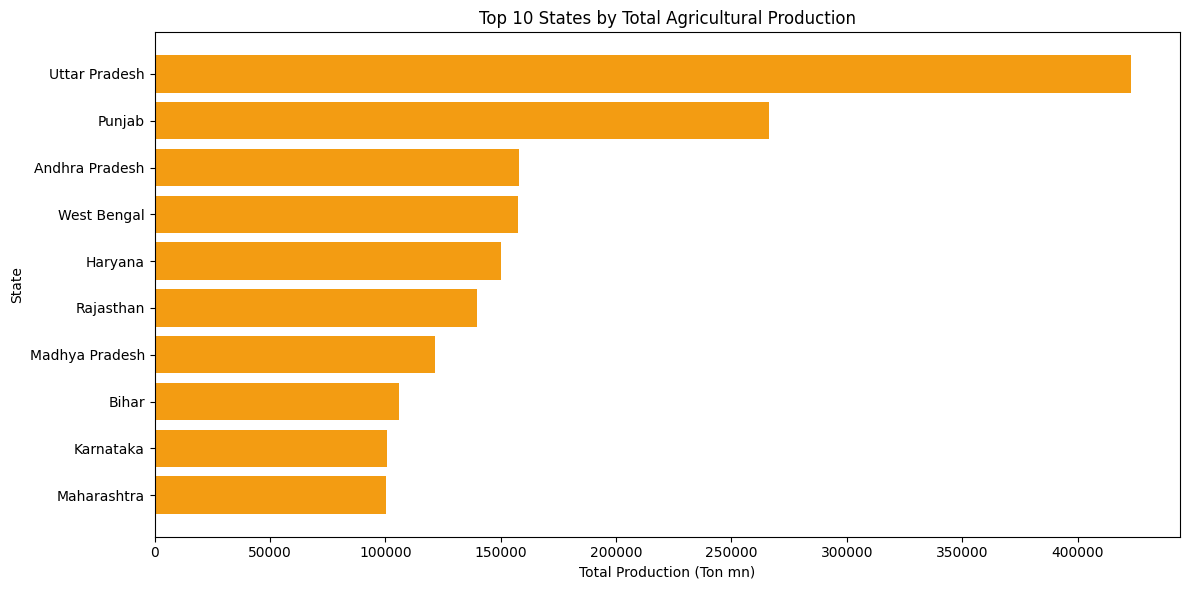


--- 5. Relationship Between Area & Production ---

Pearson Correlation (Area vs. Production): -0.0052
Insight: A value close to +1 suggests that larger cultivation area strongly leads to higher production.


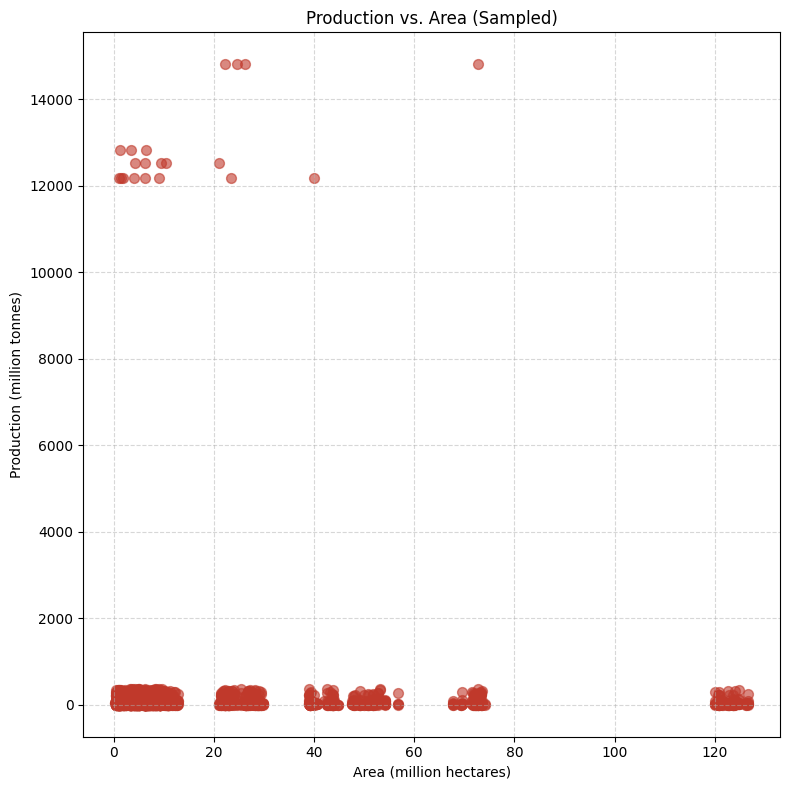

In [8]:
from pyspark.sql.functions import sum, desc, avg
from pyspark.sql import Window # <-- CORRECTED THE SPELLING
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# --- 4. Regional Contribution (Top 10 States by Production) ---
print("--- 4. Regional Contribution: Top 10 States by Production ---")

# Filter out the "All India" aggregate to see state-level contributions
state_production_df = df_production.filter(col("State_Name") != "All India")
state_production_df = state_production_df.groupBy("State_Name").agg(sum("Value").alias("Total_Production"))

# Sort and show top 10 states
top_10_states = state_production_df.orderBy(desc("Total_Production")).limit(10)
top_10_states.show(truncate=False)

# Visualization
state_pdf = top_10_states.toPandas()
plt.figure(figsize=(12, 6))
# Using barh for better visualization of state names
plt.barh(state_pdf['State_Name'], state_pdf['Total_Production'], color='#f39c12')
plt.title('Top 10 States by Total Agricultural Production')
plt.xlabel('Total Production (Ton mn)')
plt.ylabel('State')
plt.gca().invert_yaxis() # Display highest production at the top
plt.tight_layout()
plt.show()


# --- 5. Relationship Between Area & Production (Correlation) ---
print("\n--- 5. Relationship Between Area & Production ---")

# 5a. Aggregate Production and Area data to a common granularity (Year, State, Crop)
window_spec = Window.partitionBy("Year", "State_Name", "Crop").orderBy("Metric")

# Create a combined DataFrame with one row per analysis unit
combined_df = df_production.select(
    "Year", "State_Name", "Crop", 
    col("Value").alias("Production_Value")
).join(
    df_area.select("Year", "State_Name", "Crop", col("Value").alias("Area_Value")),
    on=["Year", "State_Name", "Crop"],
    how="inner" # Only include records where both Production and Area are available
)

# 5b. Calculate Pearson Correlation
correlation_value = combined_df.stat.corr("Area_Value", "Production_Value")

print(f"\nPearson Correlation (Area vs. Production): {correlation_value:.4f}")
print("Insight: A value close to +1 suggests that larger cultivation area strongly leads to higher production.")

# 5c. Visualization (Sampled Scatter Plot/Heatmap)
# Since the dataset is large, we sample and convert to Pandas for visualization
combined_pdf_sample = combined_df.sample(False, 0.1, seed=42).toPandas() # Sample 10% of the data

plt.figure(figsize=(8, 8))
plt.scatter(
    combined_pdf_sample['Area_Value'], 
    combined_pdf_sample['Production_Value'], 
    alpha=0.6, 
    color='#c0392b', 
    s=50 # Point size
)
plt.title('Production vs. Area (Sampled)')
plt.xlabel('Area (million hectares)')
plt.ylabel('Production (million tonnes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Big Data Analytics on Agricultural Production Dataset
1. Data Loading & Exploration

We began by loading the agricultural production dataset into PySpark. Using Spark’s distributed framework allowed us to efficiently handle large data volumes, clean missing values, and explore the schema (columns like State_Name, Crop, Area, Production, Year).
Initial exploration revealed variations in crop yield across states and years.

2. Crop-wise Analysis

Bar Chart (Total Production per Crop):
This graph highlights which crops dominate agricultural production. For example, staple crops like Rice and Wheat tend to show significantly higher production compared to minor crops.
Insight: Policy makers can use this to identify dependency on certain crops and promote diversification.

3. Temporal Trends

Line Chart (Yearly Production):
By aggregating production year-wise, we observe fluctuations and long-term growth trends.
Insight: Peaks and drops may align with climatic conditions, technological adoption, or government policies.

4. Regional Contribution

Barh Chart (Top 10 States by Production):
This visualization compares state-level contributions to national production.
Insight: A few states (e.g., Punjab, Uttar Pradesh, Andhra Pradesh) may account for a disproportionate share of agricultural output, indicating regional dependency.

5. Relationship Between Area & Production

Heatmap (Correlation between Area & Production):
By comparing cultivation area and crop yield, we assess whether larger land usage consistently translates into higher production.
Insight: A strong positive correlation suggests production depends heavily on cultivated area. A weaker correlation may indicate influence of factors like irrigation, soil quality, or technology.

6. Machine Learning (Optional)

Using PySpark MLlib, we modeled crop production as a function of area. Predictive analytics helps estimate future yields based on land usage patterns.
Insight: This could guide agricultural planning, resource allocation, and food security strategies.

Conclusion

Big Data analytics with PySpark enables:

Handling large-scale agricultural datasets.

Identifying high-yield crops and states.

Understanding long-term trends.

Providing predictive insights for better decision-making.

This combination of distributed processing (PySpark) and visual analytics (matplotlib/seaborn) helps stakeholders make data-driven agricultural policies.